Authors: [Yassine Rodani](https://yassine-rodani.info), [Maxime Devanne](https://maxime-devanne.com) and [Ali El Hadi Ismail Fawaz](https://hadifawaz1999.github.io)

 [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ubgcYxYcHTsF4DVahtQre1ZetwFk2FuL?usp=sharing)

# Variational AutoEncoders

A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid **overfitting** and ensure that **the latent space** has good properties that enable generative process.

> Instead of encoding an input as a single point, we encode it as a distribution $Z ∼$ 𝓝 $(0, 1)$ over the latent space.

## Architecture

![Variational autoencoder architecture](https://github.com/yassine-rd/deep-learning-course/tree/master/2-%20Autoencoder%20%26%20Variational%20Autoencoder/assets/images/vae_architecture.png)

So the goal is to have a distribution over the latent space, but how ?
- Firstly, $f$ generates two vectors $\mu$ and $\gamma$
- A distribution density can be generated from these two vectors
- A latent vector $z$ is randomly taken from the distribution
- Finaly, the reconstruction can be done $g(z)$

To learn more about variational autoencoders, please consider reading [this article](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) by [Joseph Rocca](https://medium.com/@joseph.rocca) and [Baptiste Rocca](https://medium.com/@baptiste.rocca).

In this notebook, I will introduce variational autoencoders with the human motion generation example.

 ## Human motion generation

### Importing libraries

In [20]:
import numpy as np
import pandas as pd
import os
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


### About dataset

We will be using the [MSR Action 3D](https://sites.google.com/view/wanqingli/data-sets/msr-action3d) dataset. It contains 3D skeleton sequences recorded with a depth sensor similar to the Kinect device, observing people performing different actions. Each skeleton contains a set of 20 3D joints corresponding to different body parts.

Data can be downloaded here:
- Skeleton data (X.npy) : https://maxime-devanne.com/datasets/MSRAction3D/X.npy
- Action labels (Y.npy) : https://maxime-devanne.com/datasets/MSRAction3D/Y.npy

### Loading and visualizing data

In [2]:
!wget -nc https://maxime-devanne.com/datasets/MSRAction3D/X.npy
!wget -nc https://maxime-devanne.com/datasets/MSRAction3D/Y.npy

--2022-10-23 18:03:34--  https://maxime-devanne.com/datasets/MSRAction3D/X.npy
Resolving maxime-devanne.com (maxime-devanne.com)... 213.186.33.4, 2001:41d0:1:1b00:213:186:33:4
Connecting to maxime-devanne.com (maxime-devanne.com)|213.186.33.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10342208 (9.9M)
Saving to: ‘X.npy’

X.npy               100%[===================>]   9.86M  5.48MB/s    in 1.8s    

2022-10-23 18:03:37 (5.48 MB/s) - ‘X.npy’ saved [10342208/10342208]

--2022-10-23 18:03:37--  https://maxime-devanne.com/datasets/MSRAction3D/Y.npy
Resolving maxime-devanne.com (maxime-devanne.com)... 213.186.33.4, 2001:41d0:1:1b00:213:186:33:4
Connecting to maxime-devanne.com (maxime-devanne.com)|213.186.33.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4664 (4.6K)
Saving to: ‘Y.npy’

Y.npy               100%[===================>]   4.55K  --.-KB/s    in 0s      

2022-10-23 18:03:38 (59.9 MB/s) - ‘Y.npy’ saved [4664/4664]



Defining a function that load our data

In [3]:
def load_msr():
  """
  This fucn skeleton sequences
  """
  X = np.load('X.npy')
  n_joints = 20
  dim = 3
  L = int(X.shape[1])
  X.shape=(-1, L, n_joints, dim)

  Y = np.load('Y.npy')
  le = LabelEncoder()
  Y = le.fit_transform(Y)
  
  return X, Y

Defining functions to visualize skeleton sequences

In [5]:
def create_directory(directory_path):
    """Create a new directory
    """
    if os.path.exists(directory_path):
        return None
    else:
        try:
            os.makedirs(directory_path)
        except:
            # In case another machine created the path meanwhile !:(
            return None
        return directory_path

def plot_limbs(ax, jointsX, jointsY, jointsZ):
    """Plot limbs according to Kinect V1 skeleton

    Args:
        ax: Axes3D
        jointsX:  X coordinates
        jointsY: Y coordinates
        jointsZ: Z coordinates
    """
    indexes = [19, 2]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [0, 2]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [1, 2]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [0, 7]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [7, 9]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [9, 11]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [1, 8]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [8, 10]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [10, 12]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [2, 3]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [3, 6]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [4, 6]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [5, 6]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [4, 13]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [13, 15]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [15, 17]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [5, 14]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [14, 16]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')
    indexes = [16, 18]
    ax.plot(np.take(jointsX, indexes), np.take(jointsY, indexes), np.take(jointsZ, indexes), linewidth=2, color='black')


def plot_skel(x, idx_to_plot):
    """Plot the sequence
    """
    # In fact it saves all frames as images and then create a gif of the animation
    seq = x[idx_to_plot]
    out_root_dir = 'out_/'
    out_pngs_dir = out_root_dir + 'pngs/' + str(idx_to_plot) + '/'
    out_gifs_dir = out_root_dir + 'gifs/'
    create_directory(out_pngs_dir)
    create_directory(out_gifs_dir)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=23., azim=-110)
    file_names = []
    numJoints=20
    dim=3
    for i in range(0, seq.shape[0]):
        plt.cla()
        skelX = seq[i].reshape(numJoints, dim)[:, 0]
        skelY = seq[i].reshape(numJoints, dim)[:, 2]
        skelZ = seq[i].reshape(numJoints, dim)[:, 1]
        # Plot joints
        ax.scatter(skelX, skelY, skelZ, c='green', depthshade=False)
        # Plot limbs
        plot_limbs(ax, skelX, skelY, skelZ)
        # Axes limits may have to be modified according to data (for betetr visualization)
        ax.set_xlim(-2, 2)
        ax.set_zlim(-1, 1)
        ax.set_ylim(0, 5)
        curr_file_name = str(i) + '.png'
        file_names.append(curr_file_name)
        plt.savefig(out_pngs_dir + curr_file_name)
    plt.close()
    # Create the gif
    images = []
    for file_name in file_names:
        images.append(imageio.imread(out_pngs_dir + file_name))

    out_file = out_gifs_dir + str(idx_to_plot) + '.gif'
    kargs = {'duration': 0.1}
    imageio.mimsave(out_file, images, 'GIF', **kargs)

All frames are saved as .png images, then we create a gif of the animation

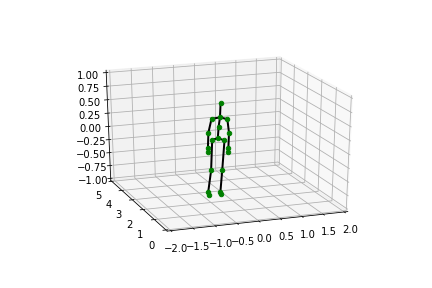

In [9]:
# Loading the frames
X, Y = load_msr()

# Visualizing skeleton animation
id_to_plot = 1
plot_skel(X, id_to_plot)
Image(open('out_/gifs/' + str(id_to_plot) + '.gif','rb').read())

Defining functions to normalize and unnormalize skeleton sequences

In [10]:
def normalizeSkelSeq(seq):
    n_seq=seq
    min_x=np.amin(n_seq[:,:,0::3])
    min_y=np.amin(n_seq[:,:,1::3])
    min_z=np.amin(n_seq[:,:,2::3])
    max_x=np.amax(n_seq[:,:,0::3])
    max_y=np.amax(n_seq[:,:,1::3])
    max_z=np.amax(n_seq[:,:,2::3])
    n_seq[:,:,0::3]=2*((n_seq[:,:,0::3]-min_x)/(max_x-min_x))-1
    n_seq[:,:,1::3]=2*((n_seq[:,:,1::3]-min_y)/(max_y-min_y))-1
    n_seq[:,:,2::3]=2*((n_seq[:,:,2::3]-min_z)/(max_z-min_z))-1
    return n_seq,min_x,min_y,min_z,max_x,max_y,max_z

In [11]:
def unnormalizeSkelSeq(seq,min_x,min_y,min_z,max_x,max_y,max_z):
    n_seq=seq
    n_seq[:,:,0::3]=((n_seq[:,:,0::3]+1)/2)*(max_x-min_x)+min_x
    n_seq[:,:,1::3]=((n_seq[:,:,1::3]+1)/2)*(max_y-min_y)+min_y
    n_seq[:,:,2::3]=((n_seq[:,:,2::3]+1)/2)*(max_z-min_z)+min_z
    return n_seq

### Building the VEA model

In [12]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to take a sample 'z', the latent vector representing an image"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Encoder

In [13]:
length_TS = X.shape[1]
n_joints = X.shape[2]
dim = X.shape[3]
latent_dim = 2

input_shape = (length_TS, n_joints, dim)
input_layer = layers.Input(input_shape)
reshape_layer = layers.Reshape(target_shape=(length_TS, n_joints*dim))(input_layer)

# Layer 1
x = layers.Conv1D(filters=128, kernel_size=20, padding='same')(reshape_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Layer 2
x = layers.Conv1D(filters=64, kernel_size=10, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Layer 3
x = layers.Conv1D(filters=32, kernel_size=5, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Layer 4
# We store the dimension before the flattent operation to reuse it in the decoder
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]

flattened_layer = layers.Flatten()(x)
dense_layer = tf.keras.layers.Dense(units=64)(flattened_layer)
encoder_mu = layers.Dense(units=latent_dim, name='encoder-mu')(dense_layer)
encoder_var = tf.keras.layers.Dense(units=latent_dim, name='encoder-var')(dense_layer)
z = Sampling()([encoder_mu, encoder_var])

encoder = Model(inputs=input_layer, outputs=[encoder_mu, encoder_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38, 20, 3)]  0           []                               
                                                                                                  
 reshape (Reshape)              (None, 38, 60)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 38, 128)      153728      ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 38, 128)     512         ['conv1d[0][0]']                 
 alization)                                                                                 

Decoder

In [15]:
input_layer = layers.Input(latent_dim)

# Layer 1
dense_layer = tf.keras.layers.Dense(units=64)(input_layer)
dense_layer = layers.Dense(units=np.prod(shape_before_flatten))(dense_layer)
reshape_layer = layers.Reshape(target_shape=shape_before_flatten)(dense_layer)

# Layer 2
x = layers.Conv1DTranspose(filters=32, kernel_size=5, padding='same')(reshape_layer)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Layer 3
x = layers.Conv1DTranspose(filters=64, kernel_size=10, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Layer 4
x = layers.Conv1DTranspose(filters=128, kernel_size=20, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_layer = layers.Conv1D(filters=n_joints*dim,kernel_size=1,padding='same')(x)
output_layer = layers.Reshape(target_shape=(length_TS, n_joints, dim))(output_layer)

decoder = Model(inputs=input_layer, outputs=output_layer, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 64)                192       
                                                                 
 dense_4 (Dense)             (None, 1216)              79040     
                                                                 
 reshape_3 (Reshape)         (None, 38, 32)            0         
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 38, 32)           5152      
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 38, 32)           128       
 hNormalization)                                           

Building the model

In [16]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Adding losses trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    # Redefining metrics
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Redefining the learning phase
    def train_step(self, data):
        # To use gradients in backpropagation, we can call GradientTape()
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Adding a layer to flatten the sequences in order to calculate the MSE loss
            flatten_function = layers.Flatten()
            # Defining reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mse(flatten_function(data), flatten_function(reconstruction))
                )
            )
            # Defining KL loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Defining total loss
            total_loss = 1.0*reconstruction_loss + 0.1*kl_loss
        # Calculating the gradient from the total loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Applying the gradient
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Updating loss values
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [18]:
n_X,min_x,min_y,min_z,max_x,max_y,max_z = normalizeSkelSeq(X)

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
history = vae.fit(n_X, epochs=200, batch_size=32, callbacks=[reduce_lr])

Epoch 1/200
18/18 [==============================] - 4s 105ms/step - loss: 5.1782 - reconstruction_loss: 3.3118 - kl_loss: 0.9050 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - 2s 106ms/step - loss: 0.6610 - reconstruction_loss: 0.4884 - kl_loss: 0.6591 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - 2s 108ms/step - loss: 0.3886 - reconstruction_loss: 0.3160 - kl_loss: 0.0237 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 2s 111ms/step - loss: 0.2747 - reconstruction_loss: 0.2590 - kl_loss: 0.0193 - lr: 0.0010
Epoch 5/200
18/18 [==============================] - 2s 107ms/step - loss: 0.2641 - reconstruction_loss: 0.2380 - kl_loss: 0.0323 - lr: 0.0010
Epoch 6/200
18/18 [==============================] - 2s 104ms/step - loss: 0.2158 - reconstruction_loss: 0.2247 - kl_loss: 0.0058 - lr: 0.0010
Epoch 7/200
18/18 [==============================] - 2s 110ms/step - loss: 0.2156 - reconstruction_loss: 0.2153 - kl_loss: 0.0029 - lr: 0.0010

Visualizing the KL and reconstruction losses

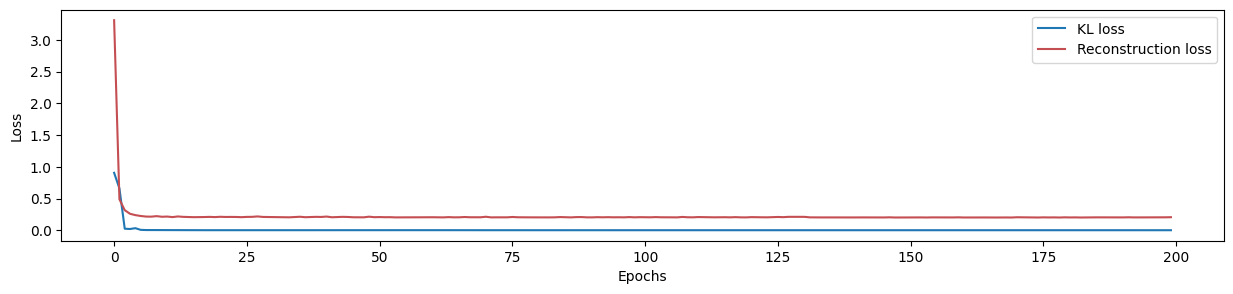

In [39]:
kl_loss = history.history['kl_loss']
reconstruction_loss = history.history['reconstruction_loss']
epochs = range(len(kl_loss))

plt.figure(figsize=(15,3))
plt.plot(epochs, kl_loss,label='KL loss', linewidth=1.5)
plt.plot(epochs, reconstruction_loss, 'r', label='Reconstruction loss', linewidth=1.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

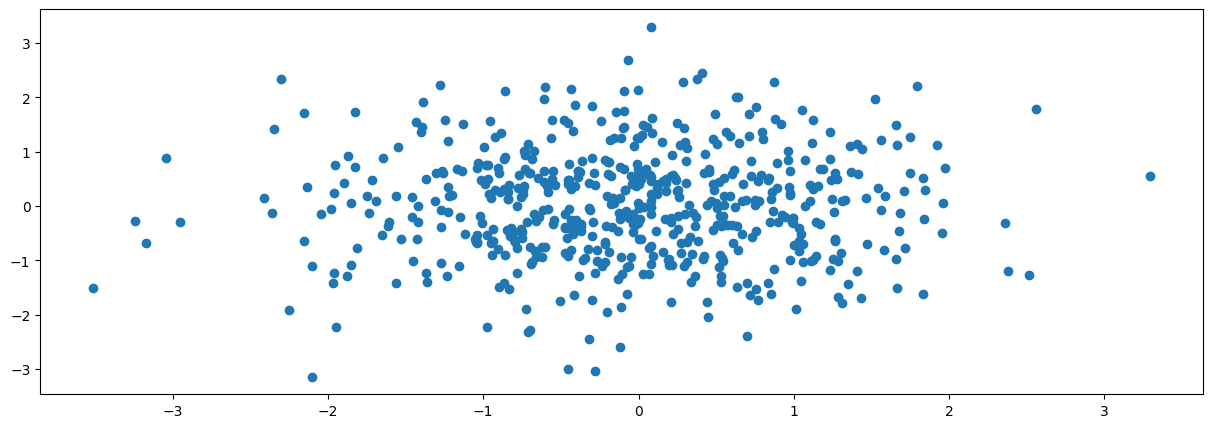

In [29]:
latent_mean, latent_var, latent_prediction = vae.encoder(n_X)
plt.figure(figsize=(15,5))
plt.scatter(latent_prediction[:, 0], latent_prediction[:, 1])

Visualizing a reconstruction sequence

In [31]:
print(latent_dim)
z_sample = np.random.normal(scale=1.0,size=(4,latent_dim))
print(z_sample)

x_decoded = vae.decoder.predict(z_sample, verbose=False)
x_decoded = unnormalizeSkelSeq(x_decoded,min_x,min_y,min_z,max_x,max_y,max_z)

2
[[-0.07618119  1.33747138]
 [ 0.23153141 -0.93041003]
 [ 1.23384809  0.80322955]
 [-1.30324435  1.3303394 ]]


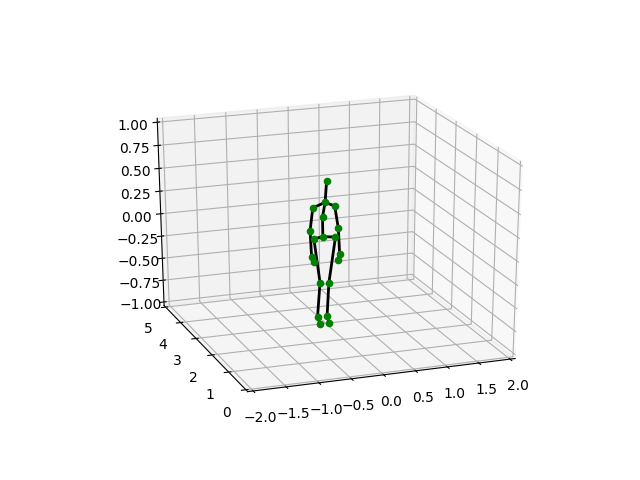

In [32]:
plot_skel(x_decoded, 0)
Image(open('out_/gifs/' + str(0) + '.gif','rb').read())